# Тестирование гипотез по увеличению выручки интернет-магазина

Мы занимаемся анализом в крупном интернет-магазине. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.


# Цель проекта.

Приоритизировать гипотезы по увеличению выручки, запустить A/B-тест и проанализировать полученные результаты.


# Задачи проекта.
Во время исследования необходимо решить следующие задачи:

1. Изучить исходные данные и провести их предобработку.
2. Произвести приоритизацию гипотез.
3. Построить и проанализировать графики кумулятивных выручки, среднего чека, конверсии по группам.
4. Построить и проанализировать графики относительного изменения кумулятивных среднего чека и конверсии группы B к группе A.
5. Определить аномальные количество и стоимость заказов пользователей.
6. Посчитать статистическую значимость различий в среднем чеке и конверсии между группами по "сырым" и "очищенным" данным.
7. Оценить результаты проведенного A/B-теста.


# Описание данных.  

<div style="border:solid black 1px; padding: 20px">   
 
Имеется несколько датафреймов со следующими данными:
    
Структура *hypothesis.csv*  
    
•	`Hypothesis` — краткое описание гипотезы;  
•	`Reach` — охват пользователей по 10-балльной шкале;  
•	`Impact` — влияние на пользователей по 10-балльной шкале;  
•	`Confidence` — уверенность в гипотезе по 10-балльной шкале;  
•	`Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
    
Структура *orders.csv*  
    
•	`transactionId` — идентификатор заказа;  
•	`visitorId` — идентификатор пользователя, совершившего заказ;  
•	`date` — дата, когда был совершён заказ;  
•	`revenue` — выручка заказа;  
•	`group` — группа A/B-теста, в которую попал заказ.  
    
Структура *visitors.csv*  
    
•	`date` — дата;  
•	`group` — группа A/B-теста;  
•	`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста      

## Импортируем библиотеки и изучим данные.

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
pd.set_option("display.precision", 2)
pd.options.display.max_colwidth = 150

In [2]:
path = 'C:\\Users\\User\\Documents\\Python Scripts\\Проект 8\\'
try:
    hypothesis, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # гипотезы
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),  # покупки
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')  # посетители
    )
except:
    hypothesis, orders, visitors = (
    pd.read_csv(path + 'hypothesis.csv'), # гипотезы 
    pd.read_csv(path + 'orders.csv'),     # покупки
    pd.read_csv(path + 'visitors.csv')    # посетители
    )

In [3]:
NORM = '\033[0m'  # все атрибуты по умолчанию
BOLD = '\033[1m'  # жирный шрифт (интенсивный цвет)

#Напишем функцию для вывода основной информации о ДФ.
df_list = [hypothesis, orders, visitors]
[hypothesis.name, orders.name, visitors.name] = (
    ['Информация о гипотезах', 'Информация о покупках', 'Информация о посещениях'])
def full_info(df_list):
    for df in df_list:
        print(BOLD+df.name)
        if len(df.index) > 10:
            print(BOLD+'\n Случайная выборка 10 строк датафрейма:')
            display (df.sample(n=10, random_state=10))
        else:
            print(BOLD+'\n Первые 10 строк датафрейма:')
            display (df.head(10))
        print(BOLD+'\n Типы данных и общая информация: \n'+NORM)
        display(df.info())
        print(BOLD+' Наличие дубликатов: '+NORM, df.duplicated().sum())
        print(BOLD+'\n Наличие пропусков: \n'+NORM)
        display(df.isna().sum())
        print(BOLD+'\n Статистики количественных переменных :')
        display(df.describe())
    return

In [4]:
full_info(df_list)

Информация о гипотезах

 Первые 10 строк датафрейма:


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

 Наличие дубликатов:  0

 Наличие пропусков: 



Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64


 Статистики количественных переменных :


,Reach,Impact,Confidence,Efforts
count,9.00,9.00,9.00,9.00
mean,4.78,4.78,5.56,4.89
std,3.15,3.19,3.05,2.80
min,1.00,1.00,1.00,1.00
25%,3.00,3.00,3.00,3.00
50%,3.00,3.00,7.00,5.00
75%,8.00,7.00,8.00,6.00
max,10.00,10.00,9.00,10.00


Информация о покупках

 Случайная выборка 10 строк датафрейма:


,transactionId,visitorId,date,revenue,group
123,3268937183,3722682546,2019-08-22,1450,A
1117,3003595335,1810540789,2019-08-13,11565,B
508,2012347492,2572275626,2019-08-06,5350,B
491,298049448,3013339133,2019-08-26,2722,B
807,2740953457,3102053760,2019-08-05,990,A
507,4067849009,2108163459,2019-08-06,580,A
482,1715714627,495712671,2019-08-06,1790,A
67,459227648,2578486380,2019-08-16,2540,B
378,1964998089,2618159035,2019-08-25,5415,A
264,3795138501,887812064,2019-08-18,170,A



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

 Наличие дубликатов:  0

 Наличие пропусков: 



transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64


 Статистики количественных переменных :


,transactionId,visitorId,revenue
count,1.20e+03,1.20e+03,1.20e+03
mean,2.16e+09,2.17e+09,8.35e+03
std,1.23e+09,1.24e+09,3.92e+04
min,1.06e+06,5.11e+06,5.00e+01
25%,1.17e+09,1.11e+09,1.22e+03
50%,2.15e+09,2.22e+09,2.98e+03
75%,3.24e+09,3.18e+09,8.29e+03
max,4.29e+09,4.28e+09,1.29e+06


Информация о посещениях

 Случайная выборка 10 строк датафрейма:


,date,group,visitors
20,2019-08-21,A,646
2,2019-08-03,A,507
31,2019-08-01,B,713
3,2019-08-04,A,717
6,2019-08-07,A,644
35,2019-08-05,B,707
19,2019-08-20,A,575
41,2019-08-11,B,721
53,2019-08-23,B,546
26,2019-08-27,A,711



 Типы данных и общая информация: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

 Наличие дубликатов:  0

 Наличие пропусков: 



date        0
group       0
visitors    0
dtype: int64


 Статистики количественных переменных :


,visitors
count,62.00
mean,607.29
std,114.40
min,361.00
25%,534.00
50%,624.50
75%,710.50
max,770.00


Аномальных значений и пропусков в данных не наблюдается. Для дальнейшего удобства и поддержания стиля только поменяем названия столбцов во всех ДФ, а так же приведем даты из строковых во временные.

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns = {'visitorId': 'visitor_id', 'transactionId': 'transaction_id'}) 

#Преобразование данных о времени

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Дополнительно проверим, корректно ли у нас проводился A/B-тест. Для этого он должен проходить по следующим параметрам:
- количество пользователей, попавших в различные группы, должно отличаться не более, чем на 0.5%;
- каждый посетитель, попавший в одну из групп теста, остаётся в этой группе до конца теста. 

In [6]:
orders.pivot_table(index = 'group', aggfunc = 'nunique')

,date,revenue,transaction_id,visitor_id
group,,,,
A,31,419,557,503
B,31,450,640,586


In [7]:
print('Количество пользователей, находящихся в обеих группах:', 
      len(list(set(orders.query('group== "A"').visitor_id) & set(orders.query('group== "B"').visitor_id))))
#orders.pivot_table(index = "group", aggfunc = "nunique")["visitor_id"].sum() - orders["visitor_id"].nunique()
#len(orders.groupby('visitor_id').agg({'group' : 'nunique'}).query('group > 1'))

Количество пользователей, находящихся в обеих группах: 58


Очевидно, что тест проведен некорректно. Имеются пользователи, попавшие в обе группы теста, их количество составляет 58 человек. К тому же, если бы фильтрация работала корректно и они попали в определенные группы, разница между ними могла бы быть в пределах 0.5%, сейчас же она составляет порядка 15%. 
При этом, удалить их не представляется возможным, т.к. мы не сможем равноценно очистить датафрейм с посетителями. Поэтому продолжим анализ теста с учетом этого недочета. 

### Вывод

<div style="border:solid green 2px; padding: 20px">
Данные изучены и предобработаны для дальнейшего исследования в части названий столбцов и типов данных дат. 
Обнаружена некорректное разделение пользователей на группы при проведении A/B-теста, что может ставить под сомнение последующий анализ и выводы, но достоверная очистка данных от них невозможна.

## Приоритизация гипотез

Для определения наиболее полезных гипотез воспользуемся методами **RICE** (*Reach* - охват, *Impact* - влияние, *Confidence* - уверенность, *Efforts* - усилия) и **ICE** - одни из самых популярных способов приоритизации задач.  
Данные показатели вычисляются по следующим формулам:

$$ICE = \frac{Impact * Confidence}{Efforts}$$
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [8]:
#Посмотрим на наиболее полезные гипотезы по методу ICE.
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'])/ hypothesis['efforts']
props = 'font-family: "Times New Roman", Times, serif; color: #e83e8c; font-size:1.3em;'
(hypothesis.sort_values(by='ICE', ascending=False)
           .style.set_table_styles([{'selector': 'td.col5', 'props': props}]))

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


In [9]:
#Посмотрим на наиболее полезные гипотезы c добавлением параметра охвата по методу RICE.
hypothesis['RICE'] = ((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/ hypothesis['efforts'])
(hypothesis.sort_values(by='RICE', ascending=False)
           .style.set_table_styles([{'selector': 'td.col6', 'props': props}]))

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


### Вывод

<div style="border:solid green 2px; padding: 20px">
При использовании метода ICE наиболее полезными гипотезами оказались следующие (в порядке убывания приоритета):
    
- №8 - скидка в день рождения
- №0 - два новых канала привлечения пользователей
- №7 - подписка на сервис для осществления рассылок

При использовании метода RICE с добавлением параметра охвата наиболее полезными гипотезами оказались следующие:
- №7 - подписка на сервис для осществления рассылок
- №2 - рекомендации товаров для повышения конверсии и среднего чека
- №0 - два новых канала привлечения пользователей
- №6 - баннеры с акциями для увеличения конверсии

Разница в результатах связана с добавлением параметра охвата пользователей, задействованных в реализации гипотезы.
**С большим отрывом наибольший приоритет получила гипотеза №7 в связи с тем, что рассылка будет затрагивать абсолютно всех пользователей, зарегистрированных на сайтах.**  
Меньший приоритет получила гипотеза с акцией в день рождения, потому что данный метод будет работать лишь раз в году, а к тому же, возможно, не все пользователи указывали дату своего рождения. Гипотеза с дополнительными каналами привлечения так же охватыват меньшее количество пользователей сайта. 

## Анализ кумулятивных выручки, среднего чека, конверсии по группам A/B-теста

Очевидно, что тест проведен некорректно. Имеются пользователи, попавшие в обе группы теста, их количество составляет 58 человек. К тому же, если бы фильтрация работала корректно и они попали в определенные группы, разница между ними могла бы быть в пределах 0.5%, сейчас же она составляет порядка 15%. 
При этом, удалить их не представляется возможным, т.к. мы не сможем равноценно очистить датафрейм с посетителями. Поэтому продолжим анализ теста с учетом этого недочета. 

In [10]:
#Создаем ДФ с уникальными парами значений 'date' и 'group', таблицы orders.
dates_groups = orders[['date', 'group']].drop_duplicates()

#Создаем на основе него ДФ с кумулятивными количеством заказов, пользователей и выручкой на каждую дату в каждой группе.

orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

#Создаем на основе него второй ДФ с кумулятивным количеством посетителей на каждую дату в каждой группе.

visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

#Объединяем данные ДФ в один

cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)

#Переименовываем столбцы

cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

Получили ДФ с кумулятивными количеством заказов, пользователей, посетителей и выручкой на каждую дату в каждой группе. По ним уже можно строить графики и видеть первоначальные результаты проведенного теста. Сделаем это.

In [11]:
#Напишем функцию для построения графиков
def graph(x1, y1, label1, x2, y2, label2, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    #Строим график выручки группы А
    plt.plot(x1, y1, label=label1)

    #Строим график выручки группы B
    plt.plot(x2, y2, label=label2)

    plt.title(title, fontsize=15)
    plt.legend(loc='upper left', fontsize='x-large')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.yticks(size = 15);

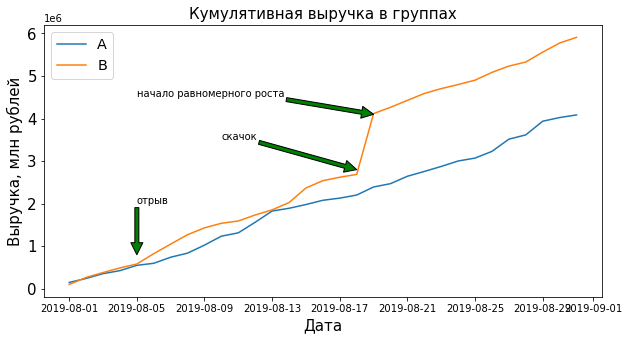

In [12]:
#Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

#Датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

graph(
    cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], 'A',
    cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], 'B',
    'Кумулятивная выручка в группах', 'Дата', 'Выручка, млн рублей')
plt.annotate('скачок', xy=('2019-08-18', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g'))
plt.annotate('начало равномерного роста', xy=('2019-08-19', 4100000), xytext=('2019-08-05', 4500000),
            arrowprops=dict(facecolor='g'))
plt.show(); 

На обоих группах кумулятивная выручка постепенно растет, это уже хорошо. При этом, можно обратить внимание, что со временем выручка в группе B значительно превосходит выручку в группе А. Но, возможно, это произошло из-за аномальных покупок в конце второй декады месяца, где виден резкий скачок выручки в группе B. Посмотрим на графики кумулятивного среднего чека.

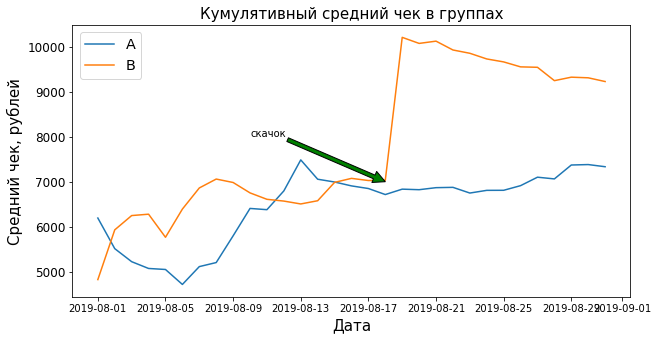

In [13]:
graph(
    cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], 'A',
    cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], 'B',
    'Кумулятивный средний чек в группах', 'Дата', 'Средний чек, рублей')
plt.annotate('скачок', xy=('2019-08-18', 7000), xytext=('2019-08-10',8000),
            arrowprops=dict(facecolor='g'))
plt.yticks(size = 12)
plt.show();

Со средним чеком ситуация аналогичная. В конце второй декады имеется резкий рост среднего чека в 1.5 раза в группе B. При этом, к концу месяца график идет на снижение, в то время как в группе A он имеет тенденцию к увеличению. Посмотрим на графики кумулятивной конверсии.

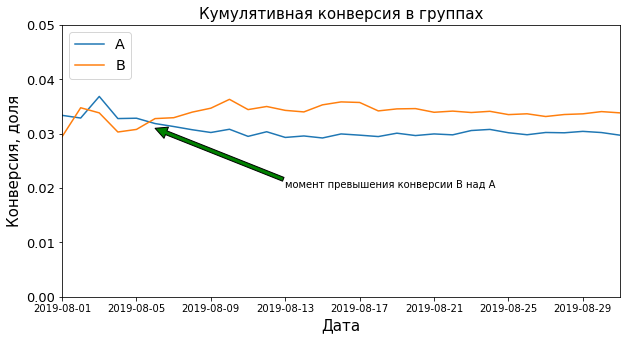

In [14]:
#Считаем кумулятивную конверсию
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

#Отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

#Отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

graph(
    cumulative_data_a['date'], cumulative_data_a['conversion'], 'A',
    cumulative_data_b['date'], cumulative_data_b['conversion'], 'B',
    'Кумулятивная конверсия в группах', 'Дата', 'Конверсия, доля')

#Задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.annotate('момент превышения конверсии B над А', xy=('2019-08-06', 0.031),
             xytext=('2019-08-13', 0.02), arrowprops=dict(facecolor='g'))
plt.yticks(size = 13)
plt.show();

Можем увидеть, что в первой декаде месяца конверсия группы B становится лучше и, стабилизировавшись на определенном уровне, так и остается выше, чем конверсия в группе А.

### Вывод

<div style="border:solid green 2px; padding: 20px">
Мы проанализировали имеющиеся данные и получили следующие предварительные результаты:  
    
- **кумулятивная выручка** растет и стабильно **выше в группе B**
- **кумулятивный средний чек выше в группе B**, но имеет тренд к снижению
- **кумулятивная конверсия** стабильна и **выше в группе B**
- **в группе В имеются явные аномальные значения**, значительно влияющие на результат, от которых необходимо очистить данные

## Анализ относительного изменения кумулятивных среднего чека и конверсии

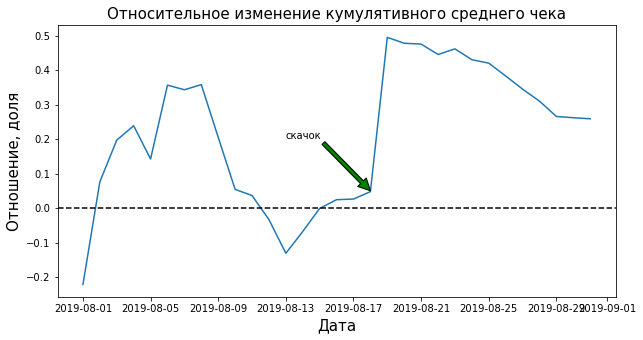

In [15]:
#Собираем данные в одном датафрейме
merged_сumulative_revenue = (cumulative_revenue_a
                             .merge(cumulative_revenue_b, left_on='date', 
                                    right_on='date', how='left', suffixes=['_a', '_b'])
                            )

#Строим отношение средних чеков
plt.figure(figsize=(10, 5))
plt.plot(merged_сumulative_revenue['date'], 
         (merged_сumulative_revenue['revenue_b']/merged_сumulative_revenue['orders_b'])
         /(merged_сumulative_revenue['revenue_a']/merged_сumulative_revenue['orders_a'])-1)

#Добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title(f"Относительное изменение кумулятивного среднего чека", fontsize=15);
plt.xlabel('Дата', fontsize=15);
plt.ylabel("Отношение, доля", fontsize=15)
plt.annotate('скачок', xy=('2019-08-18', 0.05), xytext=('2019-08-13', 0.2),
            arrowprops=dict(facecolor='g'));

По графику видно значительное превышение кумулятивного среднего чека группы А над группой В. При этом снова виден резкий скачок в конце второй декады, вызванный, вероятно, аномальными заказами. Посмотрим на график относительного изменения кумулятивной конверсии.

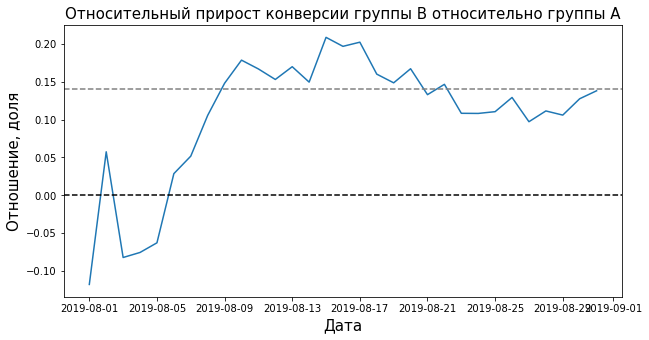

In [16]:
#Объединим наши ДФ, разделенные по группам
merged_сumulative_сonversions = (cumulative_data_a[['date','conversion']]
                                 .merge(cumulative_data_b[['date','conversion']],
                                        left_on='date', right_on='date',
                                        how='left', suffixes=['_a', '_b']))

#Построим график
plt.figure(figsize=(10, 5))
plt.plot(merged_сumulative_сonversions['date'], 
         merged_сumulative_сonversions['conversion_b']/merged_сumulative_сonversions['conversion_a']-1)
plt.title(f"Относительный прирост конверсии группы B относительно группы A", fontsize=15);
plt.xlabel('Дата', fontsize=15);
plt.ylabel("Отношение, доля", fontsize=15);

#Добавим линии на оси Y, равные нулю и разнице в конверсиях в конце теста.
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--');

По графику видно, что в первой декаде конверсия в группе В стала выше, чем в группе А, и к концу теста почти стабилизируется на уровне 15% лучше, чем конверсия в группе А.

### Вывод

<div style="border:solid green 2px; padding: 20px">
Получили следующие предварительные результаты: 
    
- **значительное превышение кумулятивного среднего чека группы А над группой В** с резким аномальным скачком в конце второй декады
- в первой декаде **конверсия в группе В стала выше, чем в группе А**, и к концу теста почти стабилизируется **на уровне 15%** лучше, чем конверсия в группе А

## Определение аномальных количества и стоимости заказов пользователей

Для начала определим визуально аномальные значения по количеству и стоимости заказов

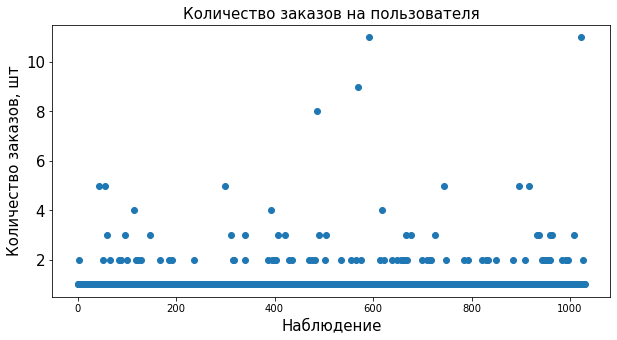

In [17]:
#Найдем число заказов по пользователям
orders_by_users = (
                    orders.groupby('visitor_id', as_index=False)
                          .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

#Серия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders_by_users['orders'])
plt.title(f"Количество заказов на пользователя", fontsize=15);
plt.xlabel('Наблюдение', fontsize=15);
plt.ylabel("Количество заказов, шт", fontsize=15)
plt.yticks(size = 15);

Визуально можно оценить, что основная часть пользователей делает один заказ, и лишь некоторые два. Большее количество заказов - единичные случае. Посмотрим на процентили.

In [18]:
print(np.percentile(orders_by_users['orders'], [90, 95, 99]))

[1. 2. 4.]


Можно сделать вывод, что лишь 5% пользователей делает более 2 заказов и лишь 1% более 4. 
Проведем аналогичные замеры со стоимостью заказов

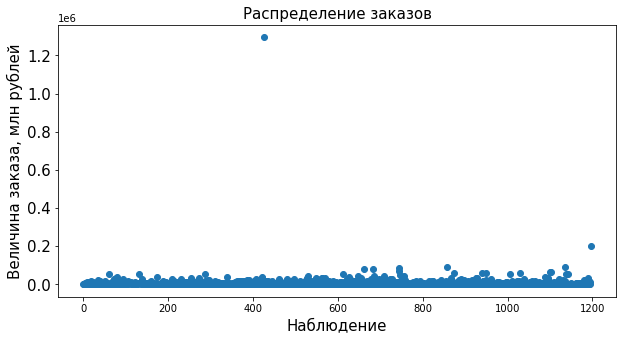

In [19]:
#Cерия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(10, 5))
plt.scatter(x_values, orders['revenue'])
plt.title(f"Распределение заказов", fontsize=15);
plt.xlabel('Наблюдение', fontsize=15);
plt.ylabel("Величина заказа, млн рублей", fontsize=15)
plt.yticks(size = 15);

Визуально достаточно сложно определить "нормальные" заказы, потому что имеется единственный аномальный заказ на 1.2 млн рублей. Основная масса сосредоточена до 100 тыс. рублей. Посмотрим на процентили.

In [20]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


Можно сделать вывод, что лишь 5% пользователей делает заказы на сумму более 28 тыс. рублей и лишь 1% на сумму более 58 тыс. рублей. 

### Вывод

<div style="border:solid green 2px; padding: 20px">
    
После проведенного анализа получилось, что лишь **5% пользователей делают более 2 заказов и лишь 5% заказов на сумму более 28 тыс. рублей**. Таким образом, логичным является их отсечение для более корректного анализа результатов A/B-теста.

## Расчет статистической значимости различий в среднем чеке и конверсии между группами по "сырым" и "очищенным" данным

### Подготовка данных для расчетов

Для расчетов сначала подготовим общий ДФ с "сырыми" данными, рассчитав ежедневное количество заказов, посетителей, выручку и их куммулятивные значения на каждую группу 

In [21]:
#Cчитаем количество посетителей и их куммулятивное значение по каждой группе.

visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date_a']

visitors_a_cummulative = visitors_a_daily.apply(
    lambda x: visitors_a_daily[visitors_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_a_cummulative.columns = ['date', 'visitors_cummulative_a']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date_b']

visitors_b_cummulative = visitors_b_daily.apply(
    lambda x: visitors_b_daily[visitors_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_b_cummulative.columns = ['date', 'visitors_cummulative_b']

#Cчитаем количество заказов и их куммулятивное значение по каждой группе.

orders_a_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_a_daily.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_a_cummulative = orders_a_daily.apply(
    lambda x: orders_a_daily[orders_a_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_a_cummulative.columns = [
    'date',
    'orders_cummulative_a',
    'revenue_cummulative_a',
]

orders_b_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_b_daily.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_b_cummulative = orders_b_daily.apply(
    lambda x: orders_b_daily[orders_b_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_b_cummulative.columns = [
    'date',
    'orders_cummulative_b',
    'revenue_cummulative_b',
]

#Объединяем все полученные ДФ в один
data = (
    orders_a_daily.merge(
        orders_b_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_b_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_a_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_b_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_a_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_b_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_a,revenue_per_date_a,orders_per_date_b,revenue_per_date_b,orders_cummulative_a,revenue_cummulative_a,orders_cummulative_b,revenue_cummulative_b,visitors_per_date_a,visitors_per_date_b,visitors_cummulative_a,visitors_cummulative_b
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


### Выбор метода определения статистической значимости различий конверсии и среднего чека

Для выбора метода определения статистической значимости этих показателей проведем проверку распределений на нормальность. Для этого воспользуемся критерием Шапиро-Уилка.

In [22]:
#Напишем для этого функцию, определяющую p-value и проверяющую гипотезу о нормальном распределении.
def norm_test(df):
    alpha = .05 # критический уровень статистической значимости
    results = stats.shapiro(df)
    p_value = results[1] # второе значение в массиве результатов (с индексом 1) - p-value
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: распределение не нормально")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, всё нормально")

In [23]:
#ДФ для проверки - количество заказов и выручка на пользователя по сырым и отфильтрованным данным соответственно.
orders_filtred = orders.groupby('visitor_id')['revenue'].sum()[orders.groupby('visitor_id')['revenue'].sum() < 28000]
orders_filtred2 = orders_by_users['orders'][orders_by_users['orders'] < 3]
dfs = [orders_by_users['orders'], orders.groupby('visitor_id')['revenue'].sum(),
       orders_filtred, orders_filtred2]
for df in dfs:
    norm_test(df)
    print('_'*50)

p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
__________________________________________________
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
__________________________________________________
p-значение:  2.7017914807604703e-33
Отвергаем нулевую гипотезу: распределение не нормально
__________________________________________________
p-значение:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
__________________________________________________


Очевидно, что все наши данные распределены ненормально, значит мы можем использовать *непараметрический тест Уилкоксона-Манна-Уитни.*

### Расчет статистической значимости различия конверсии и среднего чека по "сырым" данным

Теперь можно приступить к расчету статистической значимости различия конверсии по результатам теста.  
Для этого сформируем нулевую и альтернативную гипотезу.  
**Нулевая H0:** вероятность того, что конверсия в группе А превышает конверсию в группе В, равна 50%  
**Альтернативная H1:** вероятность того, что конверсия в группе А превышает конверсию в группе В, не равна 50%

In [24]:
#Создадим ДФ, где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов.

orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders'] 

#Создадим переменные, в которых пользователям с заказами будет соответствовать число заказов пользователя,
#а пользователям без заказов — нули.
sample_a = pd.concat([orders_by_users_a['orders'],
                       pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum()
                                                    - len(orders_by_users_a['orders'])),
                                 name='orders')],axis=0)
           
sample_b = pd.concat([orders_by_users_b['orders'],
                      pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum()
                                                   - len(orders_by_users_b['orders'])),
                                name='orders')],axis=0)

In [25]:
#Посчитаем статистическую значимость различия конверсии с помощью теста Манна-Уитни. 
#Выведем p-value для сравнения конверсии между группами.

alpha = .05 # критический уровень статистической значимости

p_val1 = stats.mannwhitneyu(sample_a, sample_b)[1]

print(f'P-value составляет: {"{0:.5f}".format(p_val1)}')

if p_val1 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

#Вычислим и выведем относительное различие в конверсии между группами
print('Относительный прирост конверсии составляет:',
      "{0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

P-value составляет: 0.01679
Отвергаем нулевую гипотезу
Относительный прирост конверсии составляет: 0.138


P-value значительно меньше 0.05, значит мы отвергаем нулевую гипотезу - по "сырым" данным между конверсиями двух групп есть статистически значимое различие.
Относительный прирост конверсии в группе В относительно группы А составляет 13.8%. 

Сравним средние чеки по "сырым" данным. Для этого сформируем нулевую и альтернативную гипотезу.  
**Нулевая H0:** вероятность того, что средний чек в группе А превышает средний чек в группе В, равна 50%  
**Альтернативная H1:** вероятность того, что средний чек в группе А превышает средний чек в группе В, не равна 50% 

In [26]:
#Посчитаем статистическую значимость различия среднего чека с помощью теста Манна-Уитни. 
#Выведем p-value для сравнения среднего чека между группами.
p_val2 = stats.mannwhitneyu(orders[orders["group"]=="A"]["revenue"],
                           orders[orders["group"]=="B"]["revenue"])[1]
print("P-value составляет:",
    '{0:.3f}'.format(p_val2))
if p_val1 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
    
#Вычислим и выведем относительное различие в среднем чеке между группами
print("Относительный прирост среднего чека составляет:",
    "{0:.3f}".format(orders[orders["group"]=="B"]["revenue"].mean() /
                     orders[orders["group"]=="A"]["revenue"].mean()-1))      

P-value составляет: 0.729
Отвергаем нулевую гипотезу
Относительный прирост среднего чека составляет: 0.259


Несмотря на то, что относительный прирост размера среднего чека в группе В относительно группы А составляет аж 25.9%, p-value значительно выше 0.05, что означает, что отвергнуть нулевую гипотезу не получилось - по "сырым" данным между средним чеком двух групп нет статистически значимого различия.  
Проведем расчеты по "очищенным" данным, проверяя те же гипотезы.

### Расчет статистической значимости различия конверсии и среднего чека по "очищенным" данным

Для начала отфильтруем наш ДФ от аномальных значений

In [27]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 2]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users

1099     148427295
18       199603092
928      204675465
23       237748145
37       249864742
           ...    
723     4009017467
627     4120364173
743     4133034833
499     4256040402
662     4266935830
Name: visitor_id, Length: 74, dtype: int64

In [28]:
#Создадим переменные, в которых пользователям с заказами будет соответствовать число заказов пользователя,
#а пользователям без заказов — нули, исключая аномальные значения
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

In [29]:
#Посчитаем статистическую значимость различия конверсии с помощью теста Манна-Уитни. 
#Выведем p-value для сравнения конверсии между группами.
p_val3 = stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1] 

print(f'P-value составляет: {"{0:.5f}".format(p_val3)}')

if p_val3 < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 
#вычислим и выведем относительное различие в конверсии между группами
print('Относительный прирост конверсии составляет:', 
      "{0:.3f}".format(sample_b_filtered.mean()/sample_a_filtered.mean()-1))

P-value составляет: 0.01304
Отвергаем нулевую гипотезу
Относительный прирост конверсии составляет: 0.173


P-value все так же значительно меньше 0.05, значит мы снова отвергаем нулевую гипотезу - по "очищенным" данным между конверсиями двух групп тоже есть статистически значимое различие.  
Относительный прирост конверсии в группе В относительно группы А стал еще больше и составляет 17.3%.  
Сравним средние чеки по "очищенным" данным.

In [30]:
sample_a_filtered = orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue']

sample_b_filtered = orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue']

In [31]:
#Посчитаем статистическую значимость различия среднего чека с помощью теста Манна-Уитни. 
#Выведем p-value для сравнения среднего чека между группами.
print("P-value составляет:",
    '{0:.3f}'.format(
        stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))

#Вычислим и выведем относительное различие в среднем чеке между группами
print("Относительный прирост среднего чека составляет:",
    "{0:.3f}".format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))      

P-value составляет: 0.738
Относительный прирост среднего чека составляет: -0.020


P-value все так же значительно выше 0.05, что означает, что отвергнуть нулевую гипотезу снова не получилось -  по "очищенным" данным между средним чеком двух групп тоже нет статистически значимого различия, и "отрицательный рост" размера среднего чека в группе В относительно группы А в 2% не имеет значения. 

### Вывод

<div style="border:solid green 2px; padding: 20px">

Расчет статистически значимого различия конверсии и среднего чека между двумя группами по "сырым" и "очищенным" различается.
        
- относительный прирост конверсии в группе В относительно группы А статистически значим и составляет 13.8%, нулевая гипотеза отвергнута    
- относительный прирост размера среднего чека в группе В относительно группы А составляет аж 25.9%, но статистически не значим, не получилось отвергнуть нулевую гипотезу 
    
При этом, **по "очищенным" данным**:  
    
- **относительный прирост конверсии** в группе В относительно группы А **статистически значим и составляет 17.3%**, нулевая гипотеза отвергнута    
- **относительный прирост размера среднего чека** в группе В относительно группы А составляет аж -2%, но **статистически не значим**, не получилось отвергнуть нулевую гипотезу

## Вывод

<div style="border:solid green 2px; padding: 20px">

В ходе предобработки и анализа данных было обнаружено некорректное разделение пользователей на группы при проведении A/B-теста, что может ставить под сомнение последующий анализ и выводы, но достоверная очистка данных от них невозможна.
    
Для приоритизации гипотез были использованы методы ICE и RICE. 
При использовании метода ICE наиболее полезными гипотезами оказались следующие (в порядке убывания приоритета):
    
- №8 - скидка в день рождения
- №0 - два новых канала привлечения пользователей
- №7 - подписка на сервис для осществления рассылок

При использовании метода RICE с добавлением параметра охвата наиболее полезными гипотезами оказались следующие:
- №7 - подписка на сервис для осществления рассылок
- №2 - рекомендации товаров для повышения конверсии и среднего чека
- №0 - два новых канала привлечения пользователей
- №6 - баннеры с акциями для увеличения конверсии

Разница в результатах связана с добавлением параметра охвата пользователей, задействованных в реализации гипотезы.
**С большим отрывом наибольший приоритет получила гипотеза №7 в связи с тем, что рассылка будет затрагивать абсолютно всех пользователей, зарегистрированных на сайтах.**  
Меньший приоритет получила гипотеза с акцией в день рождения, потому что данный метод будет работать лишь раз в году, а к тому же, возможно, не все пользователи указывали дату своего рождения. Гипотеза с дополнительными каналами привлечения так же охватыват меньшее количество пользователей сайта.     
    
Далее был проведен анализ имеющихся данных и были получены следующие предварительные результаты:  
    
- **кумулятивная выручка** растет и стабильно **выше в группе B**
- **кумулятивный средний чек выше в группе B**, но имеет тренд к снижению
- **кумулятивная конверсия** стабильна и **выше в группе B**
- **в группе В имеются явные аномальные значения**, значительно влияющие на результат, от которых необходимо очистить данные
- **значительное превышение кумулятивного среднего чека группы А над группой В** с резким аномальным скачком в конце второй декады
- в первой декаде **конверсия в группе В стала выше, чем в группе А**, и к концу теста почти стабилизируется **на уровне 15%** лучше, чем конверсия в группе А
    
Для последующей очистки данных аномалий было выяснено, что лишь **5% пользователей делают более 2 заказов и лишь 5% заказов на сумму более 28 тыс. рублей**, что и стало границами для удаления аномальных значений.
    
Наконец, было выяснено, что расчет статистически значимого различия конверсии и среднего чека между двумя группами по "сырым" и "очищенным" различается.
        
- относительный прирост конверсии в группе В относительно группы А статистически значим и составляет 13.8%, нулевая гипотеза отвергнута    
- относительный прирост размера среднего чека в группе В относительно группы А составляет аж 25.9%, но статистически не значим, не получилось отвергнуть нулевую гипотезу 
    
При этом, **по "очищенным" данным**:  
    
- **относительный прирост конверсии** в группе В относительно группы А **статистически значим и составляет 17.3%**, нулевая гипотеза отвергнута    
- **относительный прирост размера среднего чека** в группе В относительно группы А составляет аж -2%, но **статистически не значим**, не получилось отвергнуть нулевую гипотезу
    
**Таким образом, проведя этот анализ, можно заключить, что A/B-тест прошел успешно и может быть завершен.   
Следует принять второй вариант теста, т.к. несмотря на то, что статистически значимого изменения среднего чека не наблюдается, при нем у пользователей значительно выросла конверсия - на 17.3% и это изменение статистически значимо.  
Это, как следствие, означает увеличение выручки, ведущей вероятнее всего к увеличению прибыли нашего интернет-магазина** 

## Чек-лист готовности проекта

- [x]  проведена приоритизация гипотез
- [x]  построен график кумулятивной выручки по группам. 
- [x]  построен график кумулятивного среднего чека по группам. 
- [x]  построен график относительного изменения кумулятивного среднего чека группы B к группе A. 
- [x]  построен график кумулятивной конверсии по группам. 
- [x]  построен график относительного изменения кумулятивной конверсии группы B к группе A. 
- [x]  построен точечный график количества заказов по пользователям. 
- [x]  посчитаны 95-й и 99-й перцентили количества заказов на пользователя. Выбрана граница для определения аномальных пользователей.
- [x]  построен точечный график стоимостей заказов. 
- [x]  посчитаны 95-й и 99-й перцентили стоимости заказов. Выбрана границу для определения аномальных заказов.
- [x]  посчитана статистическую значимость различий в конверсии между группами по «сырым» данным. 
- [x]  посчитана статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
- [x]  посчитана статистическую значимость различий в конверсии между группами по «очищенным» данным. 
- [x]  посчитана статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. 
- [x]  принято и объяснено решение по результатам теста. 
- [x]  есть общий вывод